<a href="https://colab.research.google.com/github/dainis-boumber/av/blob/master/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ULMFiT + Siamese Network for Sentence Vectors
## Part Three: Classifying

The second notebook created a new language model from the SNLI dataset.
This notebook will adapt that model to predicting the SNLI category for sentence pairs.
The model will be used as a sentence encoder for a Siamese Network that builds sentence vectors that are feed into a classifier network.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from ipyexperiments import *
import fastai
from fastai.text import *
import html
import json
import html
import re
import pickle
from collections import Counter
import random
import pandas as pd
import numpy as np
from pathlib import Path
import sklearn
from sklearn import model_selection
from functools import partial
from collections import Counter, defaultdict
import random

import numpy as np
import torch
import torch.nn as nn
import torch.utils 
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import dataset, dataloader
import torch.optim as optim
import torch.nn.functional as F

import time
import math
import sys
import data
import joblib

token_files = './data/PAN14/tokens/'
model_files = './data/PAN14/models/'
TRAINDATAPATH = "./data/PAN14/pan14_train_english-essays/"
TESTDATAPATH = "./data/PAN14/pan14_test02_english-essays/"
FNAMES = ['known01','known02','known03','known04','known05', 'unknown']
KCOLS=['known01','known02','known03','known04','known05']
LABELCOL="answer"
UNKOWN="unknown"

In [2]:
doc_pairs_train=joblib.load(f'{model_files}traindf-2.pkl')
doc_pairs_val=joblib.load(f'{model_files}valdf-2.pkl')
doc_pairs_test=joblib.load(f'{model_files}testdf-2.pkl')

In [3]:
doc_pairs_val

,known,unknown,label
0,﻿ Increasing violence In this essay I shall r...,﻿I have now studied English for nine years in ...,0
1,﻿\tToday there is nothing strange or odd about...,﻿ The number of cellular phones in Sweden stil...,0
2,﻿ This is an argumentative essay against Morga...,﻿ The number of cellular phones in Sweden stil...,0
3,﻿ The expansion of floorball in Uppland \tI f...,"﻿ ""The rise and the fall of the Swedish school...",0
4,﻿ Let the Royal family speak organ Johansson ...,"﻿ ""The rise and the fall of the Swedish school...",0
5,﻿ Doris Lessing's The Grass Is Singing The to...,﻿ Cremation as a sign of the times For the la...,0
6,﻿ Taboo or Not Taboo In Shirley E Peckham's a...,﻿ Cremation as a sign of the times For the la...,0
7,﻿ The Times Educational Supplement A Misdirect...,﻿ Cremation as a sign of the times For the la...,0
8,﻿ Julius Caesar The following essay will be a...,﻿ Can increased car traffic have a positive ef...,1
9,﻿ Little Women - the world of women The novel...,﻿ Can increased car traffic have a positive ef...,1


In [4]:
data_lm = TextLMDataBunch.load(model_files)

In [5]:
data_clf = TextClasDataBunch.from_df(model_files, doc_pairs_train, doc_pairs_val, doc_pairs_test,
                                vocab=data_lm.train_ds.vocab, bs=64,
                                  text_cols=['known', 'unknown'], label_cols=['label'], mark_fields=True)



In [6]:
data_clf.save()          
data_clf = TextClasDataBunch.load(model_files, bs=64)

In [7]:
learn = text_classifier_learner(data_clf, drop_mult=0.5)
learn.load_encoder('healthy_enc')

In [8]:
data_clf.show_batch()

text,target
xxbos xxfld 1 xxmaj carrycot xxmaj carry - out \ s \ s \ s \ ssweet xxmaj cotton xxmaj candy \ s \ s \ s \ sbaby carriage xxmaj pushcart xxmaj formula \ s \ s \ s \ sbassinet xxmaj baggage car xxmaj billfold xxmaj barfly \ s \ s \ s \ sbre xxmaj checkerboard xxmaj draughtboard xxmaj checking account xxmaj current,1
xxbos xxfld 1 xxmaj catapult edian strip xxmaj central reservation xxmaj certified mail xxmaj recorded delivery xxmaj channel surf xxmaj channel hop xxup cpa \ s \ s \ s \ sholdall xxmaj portacrib \ s \ s \ s \ samerican football xxmaj video arcade xxmaj amusement arcade \ s \ s \ s \ stin xxmaj canadian bacon xxmaj bacon xxmaj candy \,1
xxbos xxfld 1 xxmaj babymilk xxmaj babysitter \ s \ s \ s \ sholdall xxmaj portacrib \ s \ s \ s \ sbre xxmaj rappel \ s \ s \ s \ scarrycot xxmaj carry - out \ s \ s \ s \ schildminder xxmaj bachelor party xxmaj stag night xxmaj back talk \ s \ s \ s \ sday camp xxmaj desk clerk \,1
xxbos xxfld 1 xxmaj cheque card xxmaj banker 's order \ s \ s \ s \ svest ock xxmaj turtle xxmaj turtle neck xxmaj turtle neck xxmaj polo neck xxmaj pants \ s \ s \ s \ sbias binding xxmaj ferris wheel xxmaj big wheel xxmaj billy club \ s \ s \ s \ sskirting board xxmaj beauty mark xxmaj beauty spot xxmaj,1
"xxbos xxfld 1 under the \ s \ s \ s \ s(10 ) ballet / ' baelei / / bae'lei / xxup f. \n xxmaj finally , and dealing also with the stress pattern , there are several xxmaj am . e suffixes with secondary stress and , of course , primary stressed in xxmaj br . xxup e. as it happens in : (",1


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


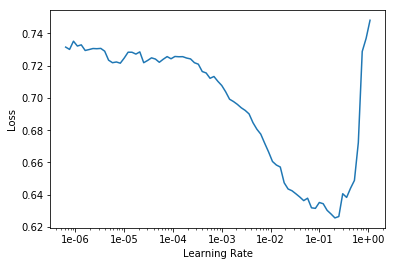

In [9]:
learn.lr_find()
learn.recorder.plot()

In [10]:
learn.save('init_av_clf1')

In [10]:
exp1=IPyExperimentsPytorch()
learn.fit_one_cycle(1, slice(1e-03, 1e-02))


*** Experiment started with the Pytorch backend
Device: ID 0, GeForce GTX 1070 (8117 RAM)


*** Current state:
RAM:  Used  Free  Total      Util
CPU:  2513 57817  64352 MB   3.91% 
GPU:  2230  5887   8117 MB  27.47% 




epoch,train_loss,valid_loss,accuracy
1,0.640155,0.667220,0.608108


･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:42.084
･ CPU:         0       3     2513 MB |
･ GPU:      -707    6542     1522 MB |


In [11]:
learn.fit_one_cycle(1, slice(1e-03, 1e-02), wd=1e-04)

epoch,train_loss,valid_loss,accuracy
1,0.500654,0.633654,0.633205


･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:42.416
･ CPU:         0       3     2513 MB |
･ GPU:       -12    6398     1510 MB |


In [12]:
learn.fit_one_cycle(1, slice(1e-03, 1e-02), wd=1e-04)

epoch,train_loss,valid_loss,accuracy
1,0.451643,0.999028,0.577220


･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:44.458
･ CPU:         0       3     2513 MB |
･ GPU:        16    6494     1526 MB |


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


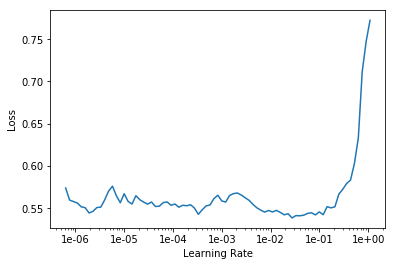

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.save('avclf_1')

In [17]:
learn.fit_one_cycle(3, slice(5e-2))

epoch,train_loss,valid_loss,accuracy
1,0.607003,0.713487,0.594595
2,0.587321,0.726404,0.594595


KeyboardInterrupt: 

In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))


epoch,train_loss,valid_loss,accuracy


RuntimeError: CUDA out of memory. Tried to allocate 40.50 MiB (GPU 0; 7.93 GiB total capacity; 3.47 GiB already allocated; 34.94 MiB free; 52.29 MiB cached)